# StackGAN

A StackGAN é uma arquitetura GAN projetada para gerar imagens fotorrealistas condicionadas a partir de descrições textuais. Algumas de suas principais características:

- Usa uma abordagem de dois estágios para quebrar o problema difícil de correlacionar texto e imagem em etapas gerenciáveis.

- No primeiro estágio, gera imagens em baixa resolução a partir da descrição textual usando uma GAN condicional (CondGAN).

- No segundo estágio, leva a descrição textual e a imagem de baixa resolução como entrada e gera a imagem final em alta resolução usando uma GAN condicional refinada. 

- Introduz uma nova função de perda que preserva tanto a informação contextual de baixa frequência quanto os detalhes visuais de alta frequência na imagem sintética final.

- Gera imagens com resolução de 64x64 pixels no primeiro estágio e 256x256 pixels no segundo estágio, muito superiores às das abordagens anteriores.

- Produz exemplos fotorrealistas de classes difíceis de imagens como pássaros, flores e móveis a partir de descrições textuais somente.

Em resumo, a StackGAN permitiu um grande avanço na síntese de imagens a partir de texto, gerando imagens de alta resolução fidedignas à descrição dada através de sua estratégia de GAN em múltiplos estágios.

Utilizaremos a arquitetura [AttnGAN](https://arxiv.org/pdf/1711.10485.pdf) (Attentional Generative Adversarial Networks) que é considerado um sucessor do StackGAN. Demonstrou conseguir resultados um pouco melhores (além disso, outro motivo para escolha foi o fato de que pro StackGAN dá muitos erros para qualquer versão do Python 3.x, já que seu código foi escrito para Python 2.x e tem muitas funções não adaptadas)

Mais sobre a AttnGAN nessa apresentação [aqui](https://on-demand.gputechconf.com/gtc/2018/presentation/s8867-attention-gan-for-fine-grained-language-to-image-generation.pdf))

## Baixar e configurar repositório

In [ ]:
!git clone https://github.com/dvschultz/AttnGAN.git

Cloning into 'AttnGAN'...
remote: Enumerating objects: 331, done.
remote: Total 331 (delta 0), reused 0 (delta 0), pack-reused 331
Receiving objects: 100% (331/331), 36.77 MiB | 41.15 MiB/s, done.
Resolving deltas: 100% (196/196), done.


In [ ]:
%cd AttnGAN

/content/AttnGAN


In [ ]:
!pip install torchvision==0.11.1
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.3 MB 95.3 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:41tcmalloc: large alloc 1147494400 bytes == 0x396bc000 @  0x7f2fe6f01615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import glob
from matplotlib import pyplot as plt

## Baixar modelo pré-treinado

Modelo treinado para o [dataset COCO](https://cocodataset.org/)

In [ ]:
d_raiz = '/content/AttnGAN/'

In [ ]:
!gdown 1i9Xkg9nU74RAvkcqKE-rJYhjvzKAMnCi -O {d_raiz}models/coco_AttnGAN2.pth

In [ ]:
!gdown 1rSnbIGNDGZeHlsUlLdahj0RJ9oo6lgH9 -O {d_raiz}data/coco.zip

In [ ]:
%cd {d_raiz}data/
!unzip coco.zip

In [ ]:
%cd coco
!unzip {d_raiz}data/coco/val2014-text.zip
!mv {d_raiz}data/coco/val2014 /content/AttnGAN/data/text

In [ ]:
%cd ../..

## Encoder

Vamos realizar o download do encoder DAMSM do dataset COCO, também necessário para gerarmos imagens com o modelo treinado. O **DAMSM** (Deep Attentional
Multimodal Similarity Model) é um dos componentes mais importantes do AttnGAN, sendo responsável por fazer a rede "entender" o texto fornecido.

Com o chamado "mecanismo de atenção" (*attention mechanism*), o DAMSM é capaz de calcular a similaridade entre a imagem gerada e a frase usando ambos as informações globais de nível de sentença e as refinadas (*fine-grained*) informações de nível de palavra (*word level information*). Há também a perda DAMSM, que segundo os autores do paper foi projetada para aprender o modelo *attention* de forma semi-supervisionada, em que a única supervisão é a correspondência entre imagens inteiras e frases (ou seja, uma sequência de palavras).

Mais informações e explicações sobre o DAMSM:
* [Paper do AttnGAN: https://arxiv.org/pdf/1711.10485.pdf](https://arxiv.org/pdf/1711.10485.pdf)
* https://on-demand.gputechconf.com/gtc/2018/presentation/s8867-attention-gan-for-fine-grained-language-to-image-generation.pdf

In [ ]:
!gdown 1zIrXCE9F6yfbEJIbNP5-YrEe2pZcPSGJ -O {d_raiz}DAMSMencoders/coco.zip

Downloading...
From: https://drive.google.com/uc?id=1zIrXCE9F6yfbEJIbNP5-YrEe2pZcPSGJ
To: /content/AttnGAN/DAMSMencoders/coco.zip
100% 116M/116M [00:02<00:00, 41.1MB/s]


In [ ]:
!unzip -d DAMSMencoders/ DAMSMencoders/coco.zip

Archive:  DAMSMencoders/coco.zip
   creating: DAMSMencoders/coco/
  inflating: DAMSMencoders/coco/image_encoder100.pth  
  inflating: DAMSMencoders/coco/text_encoder100.pth  


## Definição das legendas

As legendas são os textos que queremos transformar em imagens. É a partir dessas legendas que a GAN vai tentará gerar imagens.

In [ ]:
%%writefile {d_raiz}data/coco/example_filenames.txt
example_captions

Overwriting /content/AttnGAN/data/coco/example_filenames.txt


In [ ]:
%%writefile {d_raiz}data/coco/example_captions.txt
there was a blue dog in the park
pizza with banana
an old clock next to a sandy beach
a large slice of pizza

Overwriting /content/AttnGAN/data/coco/example_captions.txt


## Geração dos resultados

E agora podemos executar o comando que irá dizer para a rede fazer a geração das imagens.

Para isso utilizaremos do script main.py, e especificamos os parâmetros:

* `--cfg` - O arquivo .yml contendo as configurações e diretórios dos arquivos usado pelo modelo.

* `--gpu` - O id do dispositivo CUDA (GPU). No Colab (e por padrão) é `0`, portanto temos que colocar esse valor. Se não passarmos esse parâmetro será exibido um erro, já que ele tenta atribuir um valor de dispositivo diferente de 0 por padrão.

In [ ]:
%cd code/

/content/AttnGAN/code


In [ ]:
!python {d_raiz}code/main.py --cfg {d_raiz}code/cfg/eval_coco.yml --gpu 0

/content/AttnGAN/code/miscc/config.py:103: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))
Using config:
{'B_VALIDATION': False,
 'CONFIG_NAME': 'attn2',
 'CUDA': True,
 'DATASET_NAME': 'coco',
 'DATA_DIR': '../data/coco',
 'GAN': {'B_ATTENTION': True,
         'B_DCGAN': False,
         'CONDITION_DIM': 100,
         'DF_DIM': 96,
         'GF_DIM': 48,
         'R_NUM': 3,
         'Z_DIM': 100},
 'GPU_ID': 0,
 'RNN_TYPE': 'LSTM',
 'TEXT': {'CAPTIONS_PER_IMAGE': 5, 'EMBEDDING_DIM': 256, 'WORDS_NUM': 20},
 'TRAIN': {'BATCH_SIZE': 100,
           'B_NET_D': False,
           'DISCRIMINATOR_LR': 0.0002,
           'ENCODER_LR': 0.0002,
           'FLAG': False,
           'GENERATOR_LR': 0.0002,
           'MAX_EPOCH': 600,
           'NET_E': '../DAMSMencoders/coco/text_encoder100.pth',
           'NET_G': '../models/coco_AttnGAN2.pth',
    

## Visualização dos resultados

Os resultados serão salvos na pasta `models/coco_AttnGAN2/example_captions/`, que é criada instantaneamente após execução do comando (example_captions que é o nome daquele arquivo .txt onde colocamos as frases)

In [ ]:
dir_resultados = '{}models/coco_AttnGAN2/example_captions/'.format(d_raiz)

E agora vamos visualizar tudo o que há nessa pasta. Para cada frase, foi salvo 3 imagens:
* _g0 - imagem produzida no estágio 0
* _g1 - imagem produzida no estágio 1
* _g2 - imagem produzida no estágio 2

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_there-was-a-blue-dog-in-the-park_g1.png


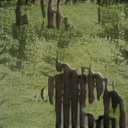

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_there-was-a-blue-dog-in-the-park_g2.png


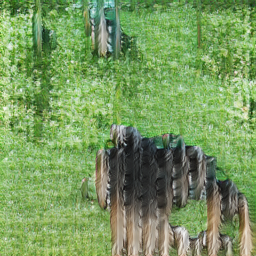

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_an-old-clock-next-to-a-sandy-beach_g1.png


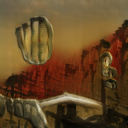

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_a-large-slice-of-pizza-_g2.png


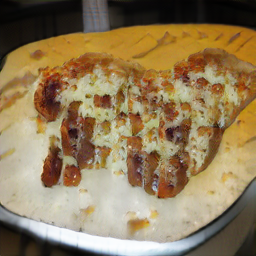

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_a-large-slice-of-pizza-_g1.png


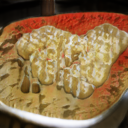

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_pizza-with-banana_g0.png


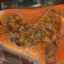

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_an-old-clock-next-to-a-sandy-beach_g2.png


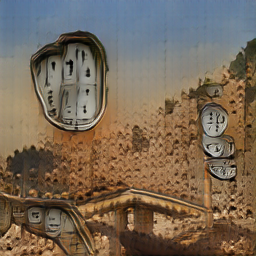

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_an-old-clock-next-to-a-sandy-beach_g0.png


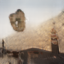

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_there-was-a-blue-dog-in-the-park_g0.png


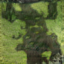

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_a-large-slice-of-pizza-_g0.png


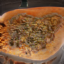

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_pizza-with-banana_g1.png


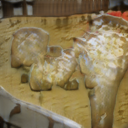

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_pizza-with-banana_g2.png


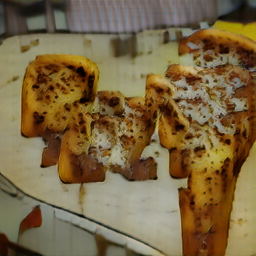

In [ ]:
imgs = glob.glob('{}*.png'.format(dir_resultados))
for i, img in enumerate(imgs):
  resultado = cv2.imread(img)
  print(img)
  cv2_imshow(resultado)

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_there-was-a-blue-dog-in-the-park_g2.png


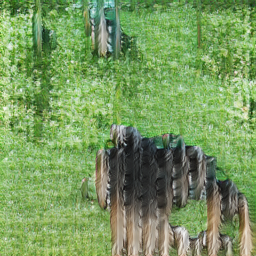

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_a-large-slice-of-pizza-_g2.png


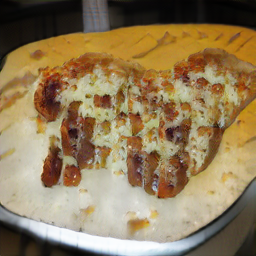

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_an-old-clock-next-to-a-sandy-beach_g2.png


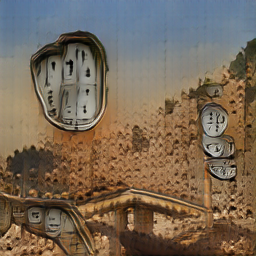

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_pizza-with-banana_g2.png


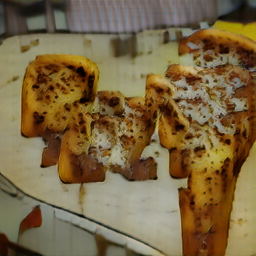

In [ ]:
imgs = glob.glob('{}*g2.png'.format(dir_resultados))
for i, img in enumerate(imgs):
  resultado = cv2.imread(img)
  print(img)
  cv2_imshow(resultado)

### Forma de visualização individual


In [ ]:
def visualizar_resultados(dir_resultados):
  imgs = glob.glob('{}*g2.png'.format(dir_resultados))
  titulo = ['G0', 'G1', 'G2']
  for i, img_caminho in enumerate(imgs):
    print(img_caminho)
    plt.figure(figsize=(12,8))
    for i in range(3):
      img_nome = img_caminho.replace("_g2", "_g{}".format(i))
      img = cv2.imread(img_nome)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.subplot(1, 3, i + 1)
      plt.title(titulo[i])
      plt.imshow(img)
      plt.axis('off')
    plt.show()

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_there-was-a-blue-dog-in-the-park_g2.png


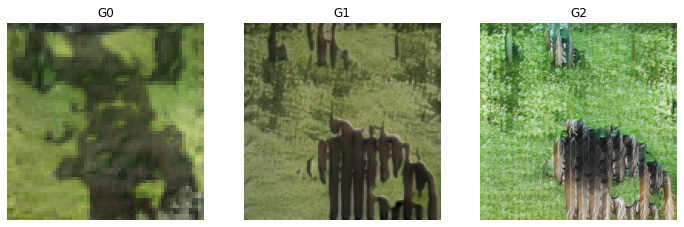

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_a-large-slice-of-pizza-_g2.png


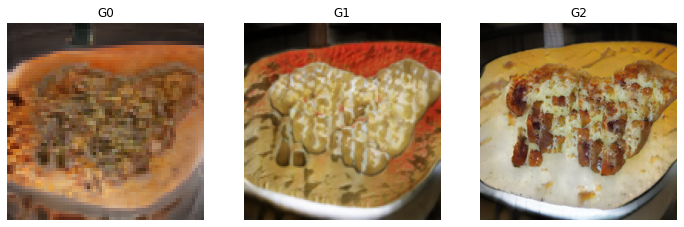

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_an-old-clock-next-to-a-sandy-beach_g2.png


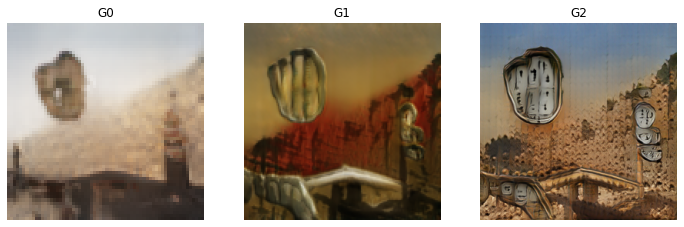

/content/AttnGAN/models/coco_AttnGAN2/example_captions/0_pizza-with-banana_g2.png


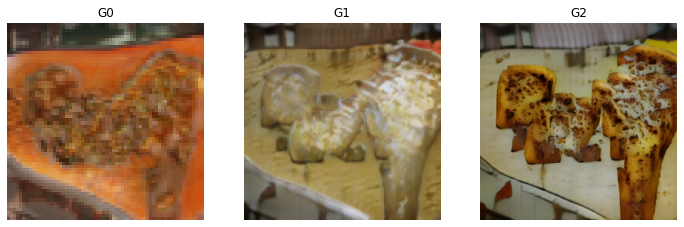

In [ ]:
visualizar_resultados(dir_resultados)

In [ ]:
!rm -rf {dir_resultados}

## Geração de imagens de pássaros

Modelo treinado usando um dataset de pássaros [CUB-200-2011 (Caltech-UCSD Birds-200-2011)](https://paperswithcode.com/dataset/cub-200-2011#:~:text=The%20Caltech%2DUCSD%20Birds%2D200%2D2011%20(CUB%2D,training%20and%205%2C794%20for%20testing.)

In [ ]:
%cd {d_raiz}

/content/AttnGAN


In [ ]:
!gdown 1lqNG75suOuR_8gjoEPYNp8VyT_ufPPig -O {d_raiz}models/birds_AttnGAN2.pth

Downloading...
From: https://drive.google.com/uc?id=1lqNG75suOuR_8gjoEPYNp8VyT_ufPPig
To: /content/AttnGAN/models/birds_AttnGAN2.pth
100% 28.5M/28.5M [00:00<00:00, 121MB/s]


In [ ]:
!gdown 1O_LtUP9sch09QH3s_EBAgLEctBQ5JBSJ -O {d_raiz}data/birds.zip

Downloading...
From: https://drive.google.com/uc?id=1O_LtUP9sch09QH3s_EBAgLEctBQ5JBSJ
To: /content/AttnGAN/data/birds.zip
100% 6.49M/6.49M [00:00<00:00, 25.7MB/s]


In [ ]:
!unzip -d data/ data/birds.zip

Archive:  data/birds.zip
   creating: data/birds/
  inflating: data/birds/.DS_Store    
   creating: data/__MACOSX/birds/
  inflating: data/__MACOSX/birds/._.DS_Store  
  inflating: data/birds/captions.pickle  
  inflating: data/birds/example_captions.txt  
  inflating: data/__MACOSX/birds/._example_captions.txt  
  inflating: data/birds/example_filenames.txt  
  inflating: data/birds/readme.txt   
  inflating: data/__MACOSX/birds/._readme.txt  
   creating: data/birds/test/
  inflating: data/birds/test/.DS_Store  
   creating: data/__MACOSX/birds/test/
  inflating: data/__MACOSX/birds/test/._.DS_Store  
  inflating: data/birds/test/class_info.pickle  
  inflating: data/__MACOSX/birds/test/._class_info.pickle  
  inflating: data/birds/test/filenames.pickle  
  inflating: data/__MACOSX/birds/test/._filenames.pickle  
  inflating: data/__MACOSX/birds/._test  
  inflating: data/birds/text.zip     
   creating: data/birds/train/
  inflating: data/birds/train/class_info.pickle  
   creating

In [ ]:
%cd data/birds/
!unzip text.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/text/159.Black_and_white_Warbler/._Black_And_White_Warbler_0135_160334.txt  
  inflating: __MACOSX/text/._159.Black_and_white_Warbler  
   creating: text/160.Black_throated_Blue_Warbler/
  inflating: text/160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0001_161189.txt  
   creating: __MACOSX/text/160.Black_throated_Blue_Warbler/
  inflating: __MACOSX/text/160.Black_throated_Blue_Warbler/._Black_Throated_Blue_Warbler_0001_161189.txt  
  inflating: text/160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0002_161533.txt  
  inflating: __MACOSX/text/160.Black_throated_Blue_Warbler/._Black_Throated_Blue_Warbler_0002_161533.txt  
  inflating: text/160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0004_161404.txt  
  inflating: __MACOSX/text/160.Black_throated_Blue_Warbler/._Black_Throated_Blue_Warbler_0004_161404.txt  
  inflating: text/160.Black_throated_Blue_Warbler/Black_Throated_Blue_W

In [ ]:
!mkdir CUB_200_2011
%cd CUB_200_2011

/content/AttnGAN/data/birds/CUB_200_2011


In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/datasets/master/tensorflow_datasets/testing/test_data/fake_examples/caltech_birds2011/extracted/TAR_GZ.CUB_200_2011.tar.gz/CUB_200_2011/images.txt
!wget https://raw.githubusercontent.com/tensorflow/datasets/master/tensorflow_datasets/testing/test_data/fake_examples/caltech_birds2011/extracted/TAR_GZ.CUB_200_2011.tar.gz/CUB_200_2011/bounding_boxes.txt

--2022-10-26 02:05:27--  https://raw.githubusercontent.com/tensorflow/datasets/master/tensorflow_datasets/testing/test_data/fake_examples/caltech_birds2011/extracted/TAR_GZ.CUB_200_2011.tar.gz/CUB_200_2011/images.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574 [text/plain]
Saving to: ‘images.txt’

images.txt          100%[===================>]     574  --.-KB/s    in 0s      

2022-10-26 02:05:27 (23.5 MB/s) - ‘images.txt’ saved [574/574]

--2022-10-26 02:05:27--  https://raw.githubusercontent.com/tensorflow/datasets/master/tensorflow_datasets/testing/test_data/fake_examples/caltech_birds2011/extracted/TAR_GZ.CUB_200_2011.tar.gz/CUB_200_2011/bounding_boxes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199

In [ ]:
%cd {d_raiz}

/content/AttnGAN


### Configurações adicionais

In [ ]:
!sed -i 's/bird_AttnGAN2.pth/birds_AttnGAN2.pth/' code/cfg/eval_bird.yml

In [ ]:
!sed -i 's/xrange/range/' code/datasets.py

### Encoder

In [ ]:
!gdown 1GNUKjVeyWYBJ8hEU-yrfYQpDOkxEyP3V

Downloading...
From: https://drive.google.com/uc?id=1GNUKjVeyWYBJ8hEU-yrfYQpDOkxEyP3V
To: /content/AttnGAN/bird.zip
100% 91.4M/91.4M [00:01<00:00, 79.1MB/s]


In [ ]:
!unzip -d DAMSMencoders/ bird.zip

Archive:  bird.zip
   creating: DAMSMencoders/bird/
  inflating: DAMSMencoders/bird/image_encoder200.pth  
  inflating: DAMSMencoders/bird/text_encoder200.pth  


### Definição de legendas

In [ ]:
%%writefile {d_raiz}data/birds/example_filenames.txt
example_captions

Overwriting /content/AttnGAN/data/birds/example_filenames.txt


In [ ]:
%%writefile {d_raiz}data/birds/example_captions.txt
black bird in the sky
there is a red and black bird in the forest
this bird is blue with black and has a short beak

Overwriting /content/AttnGAN/data/birds/example_captions.txt


### Geração dos resultados

In [ ]:
%cd code

/content/AttnGAN/code


In [ ]:
!python {d_raiz}code/main.py --cfg {d_raiz}code/cfg/eval_bird.yml --gpu 0

/content/AttnGAN/code/miscc/config.py:103: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))
Using config:
{'B_VALIDATION': False,
 'CONFIG_NAME': 'attn2',
 'CUDA': True,
 'DATASET_NAME': 'birds',
 'DATA_DIR': '../data/birds',
 'GAN': {'B_ATTENTION': True,
         'B_DCGAN': False,
         'CONDITION_DIM': 100,
         'DF_DIM': 64,
         'GF_DIM': 32,
         'R_NUM': 2,
         'Z_DIM': 100},
 'GPU_ID': 0,
 'RNN_TYPE': 'LSTM',
 'TEXT': {'CAPTIONS_PER_IMAGE': 10, 'EMBEDDING_DIM': 256, 'WORDS_NUM': 25},
 'TRAIN': {'BATCH_SIZE': 100,
           'B_NET_D': False,
           'DISCRIMINATOR_LR': 0.0002,
           'ENCODER_LR': 0.0002,
           'FLAG': False,
           'GENERATOR_LR': 0.0002,
           'MAX_EPOCH': 600,
           'NET_E': '../DAMSMencoders/bird/text_encoder200.pth',
           'NET_G': '../models/birds_AttnGAN2.pth',


In [ ]:
dir_resultados = '{}models/birds_AttnGAN2/example_captions/'.format(d_raiz)

In [ ]:
ls {dir_resultados}

0_black-bird-in-the-sky_g0.png
0_black-bird-in-the-sky_g1.png
0_black-bird-in-the-sky_g2.png
0_there-is-a-red-and-black-bird-in-the-forest_g0.png
0_there-is-a-red-and-black-bird-in-the-forest_g1.png
0_there-is-a-red-and-black-bird-in-the-forest_g2.png
0_this-bird-is-blue-with-black-and-has-a-short-beak_g0.png
0_this-bird-is-blue-with-black-and-has-a-short-beak_g1.png
0_this-bird-is-blue-with-black-and-has-a-short-beak_g2.png


/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-and-black-bird-in-the-forest_g0.png


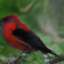

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-and-black-bird-in-the-forest_g2.png


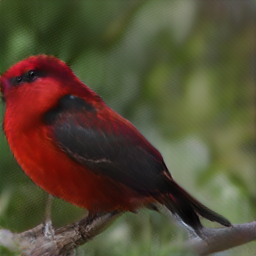

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_black-bird-in-the-sky_g1.png


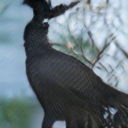

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-and-black-bird-in-the-forest_g1.png


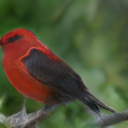

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_this-bird-is-blue-with-black-and-has-a-short-beak_g2.png


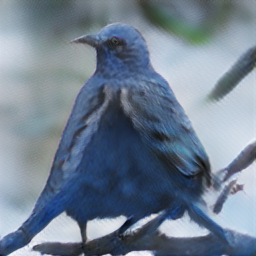

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_black-bird-in-the-sky_g0.png


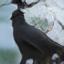

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_black-bird-in-the-sky_g2.png


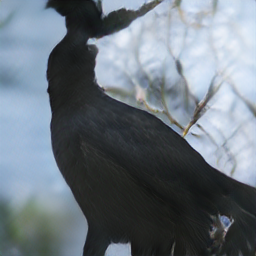

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_this-bird-is-blue-with-black-and-has-a-short-beak_g0.png


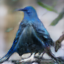

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_this-bird-is-blue-with-black-and-has-a-short-beak_g1.png


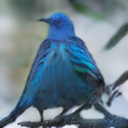

In [ ]:
imgs = glob.glob('{}*.png'.format(dir_resultados))

for i, img in enumerate(imgs):
  resultado = cv2.imread(img)
  print(img)
  cv2_imshow(resultado)

In [ ]:
visualizar_resultados(dir_resultados)

In [ ]:
%%writefile {d_raiz}data/birds/example_captions.txt
the bird has wings that are red and has a yellow belly
this bird is yellow and has a black belly
the bird has wings that are blue and has a red belly

In [ ]:
!python {d_raiz}code/main.py --cfg {d_raiz}code/cfg/eval_bird.yml --gpu 0

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_the-bird-has-wings-that-are-red-and-has-a-yellow-belly_g2.png


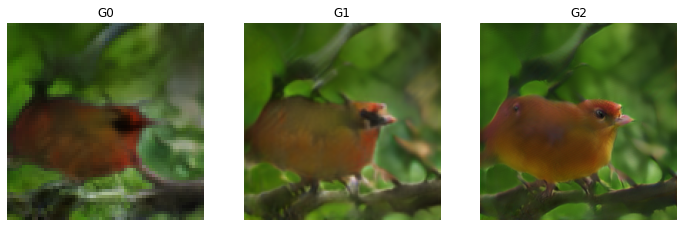

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_this-bird-is-yellow-and-has-a-black-belly_g2.png


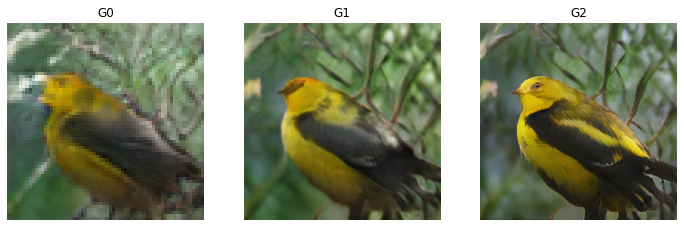

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-and-black-bird-in-the-forest_g2.png


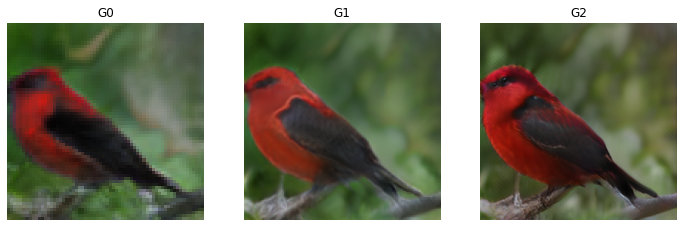

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_this-bird-is-blue-with-black-and-has-a-short-beak_g2.png


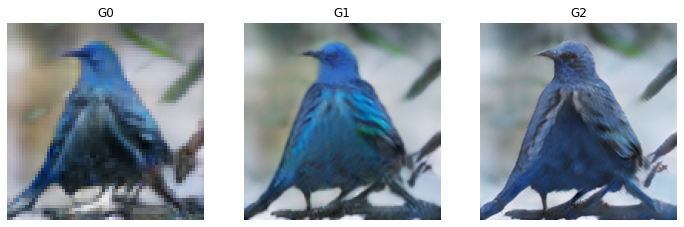

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_the-bird-has-wings-that-are-blue-and-has-a-red-belly_g2.png


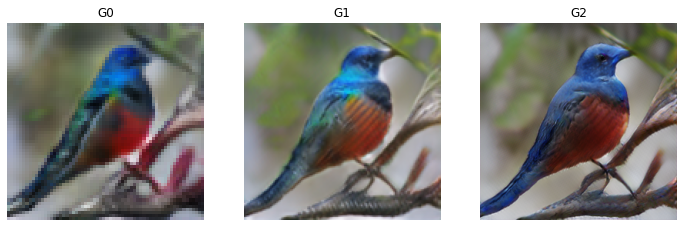

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_black-bird-in-the-sky_g2.png


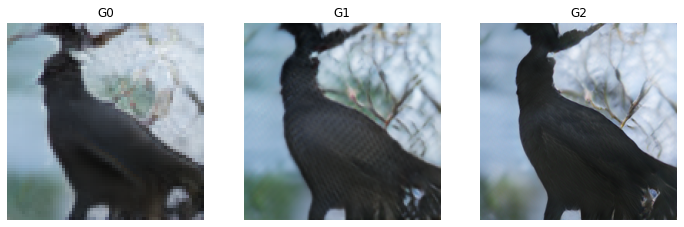

In [ ]:
visualizar_resultados(dir_resultados)

---

Código baseado no paper:
* [AttnGAN: Fine-Grained Text to Image Generation with Attentional Generative Adversarial Networks](https://arxiv.org/pdf/1711.10485.pdf)
* [StackGAN: Text to Photo-realistic Image Synthesis with Stacked Generative Adversarial Networks](https://arxiv.org/pdf/1612.03242v1.pdf)

Repositório oficial:
* https://github.com/taoxugit/AttnGAN



---


## Exercício

> Crie imagens através de suas próprias legendas para criar diversas variações

Nesse exercício, você deve testar como ficará a geração após variar as suas características. Primeiro, escolha um atributo e então defina variações a partir dele.
* Gere legendas para o seguinte exemplo:
 * há um pássaro vermelho com asa { branca / amarela / azul / verde / preta / roxa } sentado sobre o galho

In [ ]:
!rm -rf {dir_resultados}

In [ ]:
#!touch {d_raiz}data/birds/captions_exercicio.txt

In [ ]:
%%writefile {d_raiz}data/birds/example_captions.txt
there is a red bird with white wings sitting on a branch
there is a red bird with orange wings sitting on a branch
there is a red bird with blue wings sitting on a branch
there is a red bird with green wings sitting on a branch
there is a red bird with black wings sitting on a branch
there is a red bird with purple wings sitting on a branch

Overwriting /content/AttnGAN/data/birds/example_captions.txt


In [ ]:
!python {d_raiz}code/main.py --cfg {d_raiz}code/cfg/eval_bird.yml --gpu 0

/content/AttnGAN/code/miscc/config.py:103: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))
Using config:
{'B_VALIDATION': False,
 'CONFIG_NAME': 'attn2',
 'CUDA': True,
 'DATASET_NAME': 'birds',
 'DATA_DIR': '../data/birds',
 'GAN': {'B_ATTENTION': True,
         'B_DCGAN': False,
         'CONDITION_DIM': 100,
         'DF_DIM': 64,
         'GF_DIM': 32,
         'R_NUM': 2,
         'Z_DIM': 100},
 'GPU_ID': 0,
 'RNN_TYPE': 'LSTM',
 'TEXT': {'CAPTIONS_PER_IMAGE': 10, 'EMBEDDING_DIM': 256, 'WORDS_NUM': 25},
 'TRAIN': {'BATCH_SIZE': 100,
           'B_NET_D': False,
           'DISCRIMINATOR_LR': 0.0002,
           'ENCODER_LR': 0.0002,
           'FLAG': False,
           'GENERATOR_LR': 0.0002,
           'MAX_EPOCH': 600,
           'NET_E': '../DAMSMencoders/bird/text_encoder200.pth',
           'NET_G': '../models/birds_AttnGAN2.pth',


/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-bird-with-blue-wings-sitting-on-a-branch_g2.png


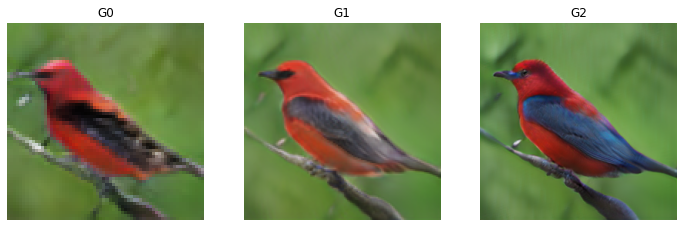

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-bird-with-black-wings-sitting-on-a-branch_g2.png


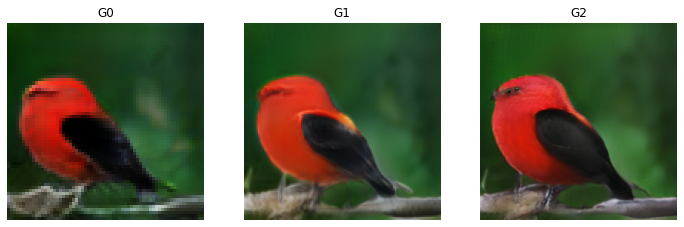

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-bird-with-green-wings-sitting-on-a-branch_g2.png


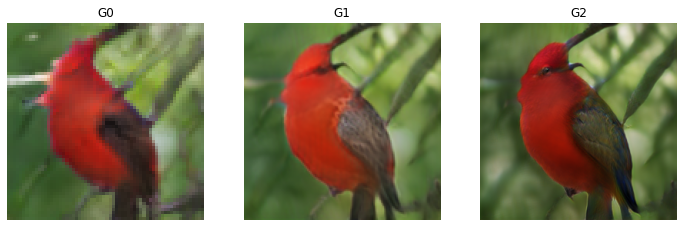

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-bird-with-purple-wings-sitting-on-a-branch_g2.png


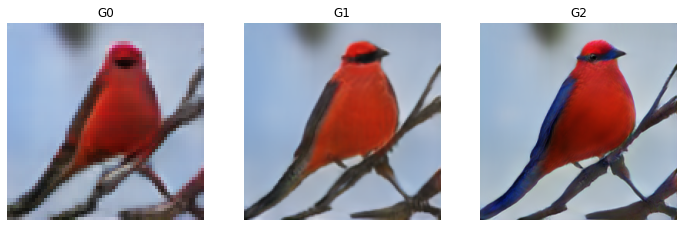

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-bird-with-orange-wings-sitting-on-a-branch_g2.png


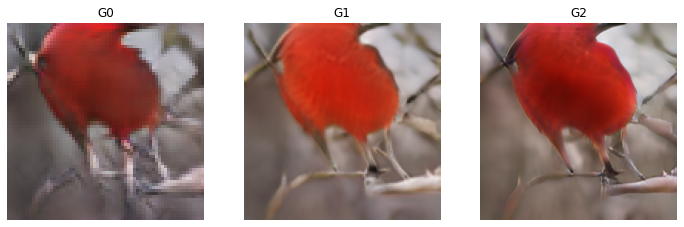

/content/AttnGAN/models/birds_AttnGAN2/example_captions/0_there-is-a-red-bird-with-white-wings-sitting-on-a-branch_g2.png


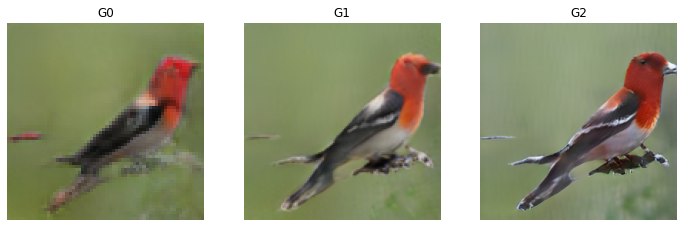

In [ ]:
dir_resultados = '{}models/birds_AttnGAN2/example_captions/'.format(d_raiz)
visualizar_resultados(dir_resultados)